In [1]:
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import yaml
from ecomplexity import ecomplexity

with open("../OkabeIto.yaml", "r") as fp:
    OkabeIto = yaml.safe_load(fp)

with open("../plotting_config.yaml", "r") as fp:
    config = yaml.safe_load(fp)

In [2]:
CRS = 2449
x_ratio = 0.9
y_ratio = 1.1

mobility_data = "../data/yjmob100k"
output = "../output"
figure_output = "../figures"

In [3]:
grid = gpd.read_file(f"{output}/grid_bl_{CRS}.geojson", engine="pyogrio")
grid["id"] = grid.apply(lambda x: f'{x["x"]:03d}-{x["y"]:03d}', axis=1)

In [4]:
pois = pd.read_csv(f"{mobility_data}/cell_POIcat.csv", engine="pyarrow")
pois["id"] = pois.apply(lambda x: f'{x["x"]:03d}-{x["y"]:03d}', axis=1)
# ecomplexity requires a time column
pois["time"] = 0
pois.head(3)

,x,y,POIcategory,POI_count,id,time
0,1,1,48,4,001-001,0
1,1,1,58,1,001-001,0
2,1,1,59,1,001-001,0


In [5]:
key_cols = {
    "time": "time",
    "loc": "id",
    "prod": "POIcategory",
    "val": "POI_count",
}
complexity_df = ecomplexity(pois.drop(["x", "y"], axis=1), key_cols)
complexity_df.head(3)

0


,id,POIcategory,POI_count,time,diversity,ubiquity,mcp,eci,pci,density,coi,cog,rca
0,001-001,1,0,0,6,670,0,-0.582165,2.891999,0.026515,-0.560716,1.743930,0.0
1,001-001,2,0,0,6,32,0,-0.582165,4.288346,0.005302,-0.560716,2.523133,0.0
2,001-001,3,0,0,6,295,0,-0.582165,0.909005,0.029462,-0.560716,0.621055,0.0


In [6]:
# Adapted from 'Amenity complexity and urban locations of socio-economic mixing' code by Juhász et al.
def create_location_complexity_table(
    location_data: gpd.GeoDataFrame, complexity_data: pd.DataFrame
) -> gpd.GeoDataFrame:
    location_complexity = pd.merge(
        location_data,
        complexity_data[["id", "eci", "diversity"]].drop_duplicates(),
        on="id",
        how="left",
    )

    ubi_temp = (
        complexity_data[complexity_data["rca"] >= 1]  # why?
        .groupby(["id"])
        .agg(avg_ubiquity=pd.NamedAgg("ubiquity", "mean"))
        .reset_index()
    )

    location_complexity = pd.merge(location_complexity, ubi_temp, on="id", how="left")

    # normalization
    location_complexity["eci_norm"] = (
        location_complexity["eci"] - location_complexity["eci"].min()
    ) / (location_complexity["eci"].max() - location_complexity["eci"].min())
    location_complexity["div_norm"] = (
        location_complexity["diversity"] - location_complexity["diversity"].min()
    ) / (
        location_complexity["diversity"].max() - location_complexity["diversity"].min()
    )
    return location_complexity

In [7]:
location_complexity = create_location_complexity_table(grid, complexity_df)
location_complexity.head(3)

,y,x,geometry,id,eci,diversity,avg_ubiquity,eci_norm,div_norm
0,1,1,"POLYGON ((-60681.818 -166666.667, -60227.273 -...",001-001,-0.582165,6.0,5427.5,0.279738,0.121951
1,2,1,"POLYGON ((-60227.273 -166666.667, -59772.727 -...",001-002,-0.327800,5.0,4387.0,0.317354,0.097561
2,3,1,"POLYGON ((-59772.727 -166666.667, -59318.182 -...",001-003,-0.324240,10.0,4727.9,0.317881,0.219512


<Axes: >

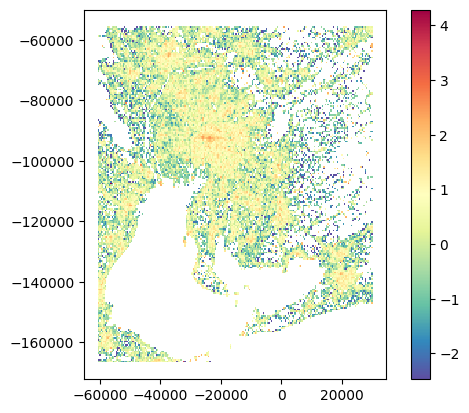

In [8]:
location_complexity.plot(column="eci", legend=True, cmap="Spectral_r")

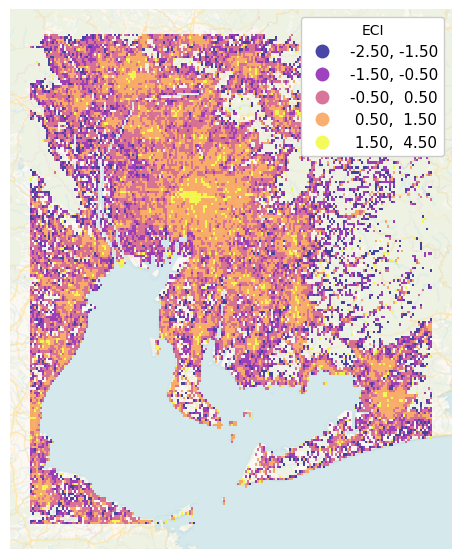

In [9]:
f, a = plt.subplots(figsize=(5 * x_ratio, 5 * y_ratio), layout="constrained")
location_complexity.plot(
    column="eci",
    legend=True,
    cmap="plasma",
    alpha=0.75,
    scheme="UserDefined",
    classification_kwds=dict(bins=[-1.5, -0.5, 0.5, 1.5, 4.5], lowest=-2.5),
    legend_kwds=dict(framealpha=1, title="ECI", fontsize=11),
    ax=a,
)
cx.add_basemap(
    a,
    crs=location_complexity.crs,
    source=cx.providers.CartoDB.VoyagerNoLabels,
    alpha=1,
    attribution=False,
)
a.axis("off")
for i in config["formats"]:
    f.savefig(
        f"{figure_output}/grid_complexity.{i}", dpi=150, metadata=config["metadata"]
    )

In [10]:
location_complexity.to_file(f"{output}/grid_complexity.geojson", driver="GeoJSON")